# S&P 500 Pairs Trading Strategy: Development and Validation

This notebook documents the end-to-end process of developing, testing, and validating a statistical arbitrage pairs trading strategy on S&P 500 stocks. The primary goal is to build a robust system that can adapt to changing market conditions and prove its viability through rigorous, out-of-sample testing.

The notebook is structured into five distinct phases:
1.  **Data Acquisition and Preparation:** Sourcing a current list of S&P 500 constituents and downloading their historical price data.
2.  **Initial "Naive" Strategy:** Building a simple version of the strategy to establish a baseline.
3.  **Sensitivity Analysis & Bug Discovery:** Stress-testing the naive strategy, uncovering a critical flaw, and correcting it.
4.  **Robust, Adaptive Strategy Development:** Enhancing the strategy with advanced features like rolling formation periods, stationarity filters, and risk management.
5.  **Final Walk-Forward Validation:** Performing a true out-of-sample test on recent, unseen data to definitively validate the strategy's performance.

## Phase 1: Data Acquisition and Preparation

### Step 1.1: Scraping S&P 500 Tickers and Sectors

To ensure our universe of stocks is current and relevant, we begin by dynamically scraping the list of S&P 500 components and their GICS sectors directly from Wikipedia. This avoids using a static, outdated list and allows us to categorize pairs by sector for later analysis.

In [1]:
import pandas as pd
import yfinance as yf
import time
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [10]:
# Cell 2 (Updated): Get Tickers AND Sectors

def get_sp500_data():
    """
    Scrapes the list of S&P 500 tickers and their GICS sectors from Wikipedia.
    
    Returns:
        pd.DataFrame: DataFrame with 'Symbol' and 'GICS Sector' columns
    """
    try:
        print("Fetching S&P 500 tickers and sectors from Wikipedia...")
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        tables = pd.read_html(url)
        sp500_table = tables[0]
        sp500_table['Symbol'] = sp500_table['Symbol'].str.replace('.', '-')
        print(f"✓ Successfully found {len(sp500_table)} S&P 500 entries")
        return sp500_table[['Symbol', 'GICS Sector']]
        
    except Exception as e:
        print(f"✗ Error fetching data: {e}")
        return pd.DataFrame()

# Get the data
sp500_df = get_sp500_data()

# The 'tickers' list is still needed for the download function
tickers = sp500_df['Symbol'].tolist()
print(f"\nSample Sectors:\n{sp500_df.head()}")

Fetching S&P 500 tickers and sectors from Wikipedia...
✓ Successfully found 503 S&P 500 entries

Sample Sectors:
  Symbol             GICS Sector
0    MMM             Industrials
1    AOS             Industrials
2    ABT             Health Care
3   ABBV             Health Care
4    ACN  Information Technology


# Step 1.2: Robust Data Download and Cleaning
Downloading historical data for over 500 tickers can be prone to network timeouts or issues with specific delisted stocks. To handle this, we download the data in batches. If a batch fails, the script pauses briefly before retrying, making the process resilient.
After downloading, we perform crucial cleaning steps:
Remove Tickers with Insufficient Data: We drop any stocks that don't have enough historical data for our analysis period (e.g., newly IPO'd companies).
Handle Missing Values (NaNs): We use forward-fill and backward-fill to handle any occasional missing daily price points, which is a standard practice.

In [3]:
def download_data_batch(tickers, start_date='2020-01-01', end_date='2023-12-31', batch_size=50):
    """
    Downloads historical adjusted close prices in batches to handle timeouts.
    
    Args:
        tickers (list): List of ticker symbols
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        batch_size (int): Number of tickers to download at once
    
    Returns:
        pd.DataFrame: DataFrame with adjusted close prices
    """
    print(f"Downloading data for {len(tickers)} tickers from {start_date} to {end_date}...")
    print(f"Using batch size: {batch_size}")
    
    all_data = {}
    failed_tickers = []
    
    # Process in batches
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i+batch_size]
        batch_num = (i // batch_size) + 1
        total_batches = (len(tickers) + batch_size - 1) // batch_size
        
        print(f"\nProcessing batch {batch_num}/{total_batches} ({len(batch)} tickers)...")
        
        try:
            # Download with increased timeout and retries
            data = yf.download(batch, start=start_date, end=end_date, 
                             progress=False, auto_adjust=True, 
                             timeout=30, threads=True)
            
            if data.empty:
                print(f"No data returned for batch {batch_num}")
                failed_tickers.extend(batch)
                continue
            
            # Handle single ticker case
            if len(batch) == 1:
                if 'Adj Close' in data.columns:
                    all_data[batch[0]] = data['Adj Close']
                else:
                    all_data[batch[0]] = data['Close']  # Fallback
            else:
                # Multi-ticker case
                if isinstance(data.columns, pd.MultiIndex):
                    if 'Adj Close' in data.columns.levels[0]:
                        adj_close_data = data['Adj Close']
                    else:
                        adj_close_data = data['Close']  # Fallback
                    
                    for ticker in batch:
                        if ticker in adj_close_data.columns:
                            all_data[ticker] = adj_close_data[ticker]
                        else:
                            failed_tickers.append(ticker)
                else:
                    # Single level columns
                    for ticker in batch:
                        if ticker in data.columns:
                            all_data[ticker] = data[ticker]
                        else:
                            failed_tickers.append(ticker)
            
            print(f"✓ Batch {batch_num} completed successfully")
            time.sleep(1)  # Brief pause between batches
            
        except Exception as e:
            print(f"✗ Batch {batch_num} failed: {e}")
            failed_tickers.extend(batch)
            time.sleep(2)  # Longer pause after failure
    
    # Combine all data
    if all_data:
        combined_data = pd.DataFrame(all_data)
        print(f"\n✓ Successfully downloaded {len(combined_data.columns)} tickers")
        if failed_tickers:
            print(f"✗ Failed to download {len(failed_tickers)} tickers: {failed_tickers[:10]}...")
        
        return combined_data
    else:
        print("✗ No data was successfully downloaded")
        return pd.DataFrame()

def clean_data(price_data, min_data_threshold=0.8):
    """
    Clean the price data by handling missing values.
    
    Args:
        price_data (pd.DataFrame): Raw price data
        min_data_threshold (float): Minimum fraction of data required to keep a ticker
    
    Returns:
        pd.DataFrame: Cleaned price data
    """
    if price_data.empty:
        return price_data
    
    print(f"Cleaning data. Initial shape: {price_data.shape}")
    
    # Remove tickers with too much missing data
    min_periods = int(min_data_threshold * len(price_data))
    clean_data = price_data.dropna(axis=1, thresh=min_periods)
    
    print(f"After removing tickers with <{min_data_threshold*100}% data: {clean_data.shape}")
    
    if clean_data.empty:
        print("Warning: All tickers removed due to insufficient data. Lowering threshold...")
        # Try with lower threshold
        min_periods = int(0.5 * len(price_data))
        clean_data = price_data.dropna(axis=1, thresh=min_periods)
        print(f"With 50% threshold: {clean_data.shape}")
    
    # Forward fill and backward fill remaining NaN values
    clean_data = clean_data.ffill().bfill()
    
    # Final check
    remaining_nans = clean_data.isnull().sum().sum()
    if remaining_nans > 0:
        print(f"Warning: {remaining_nans} NaN values remain")
        # Drop any columns that still have NaNs
        clean_data = clean_data.dropna(axis=1)
        print(f"After final NaN removal: {clean_data.shape}")
    
    print(f"✓ Data cleaning complete. Final shape: {clean_data.shape}")
    return clean_data

# Step 1.3: Splitting Data to Prevent Lookahead Bias
This is one of the most critical steps in any backtesting project. To avoid lookahead bias, where the model is unfairly influenced by data it wouldn't have had at the time, we split our historical data into two distinct, non-overlapping periods:
Formation Period (2020-2021): This "in-sample" data is used to discover the cointegrated pairs. The strategy learns the relationships between stocks from this period only.
Trading Period (2022-2023): This "out-of-sample" data is used to backtest the strategy. We simulate trading the pairs found in the formation period to see how they would have actually performed.

In [4]:
print("Starting robust batch download...")
raw_price_data = download_data_batch(tickers, start_date='2020-01-01', end_date='2023-12-31', batch_size=25)

# Clean the data
price_data = clean_data(raw_price_data, min_data_threshold=0.8)

# Display basic info about the data
if not price_data.empty:
    print(f"\n" + "="*50)
    print("DOWNLOAD SUMMARY")
    print("="*50)
    print(f"Final data shape: {price_data.shape}")
    print(f"Date range: {price_data.index[0].strftime('%Y-%m-%d')} to {price_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"Successfully downloaded: {len(price_data.columns)} tickers")
    print(f"Sample tickers: {list(price_data.columns[:10])}")
    print("="*50)
else:
    print("❌ No data was successfully downloaded. Check your internet connection and try again.")

Starting robust batch download...
Using batch size: 25

Processing batch 1/21 (25 tickers)...
✓ Batch 1 completed successfully

Processing batch 2/21 (25 tickers)...
✓ Batch 2 completed successfully

Processing batch 3/21 (25 tickers)...
✓ Batch 3 completed successfully

Processing batch 4/21 (25 tickers)...
✓ Batch 4 completed successfully

Processing batch 5/21 (25 tickers)...
✓ Batch 5 completed successfully

Processing batch 6/21 (25 tickers)...
✓ Batch 6 completed successfully

Processing batch 7/21 (25 tickers)...
✓ Batch 7 completed successfully

Processing batch 8/21 (25 tickers)...
✓ Batch 8 completed successfully

Processing batch 9/21 (25 tickers)...



1 Failed download:
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1703998800")')


✓ Batch 9 completed successfully

Processing batch 10/21 (25 tickers)...
✓ Batch 10 completed successfully

Processing batch 11/21 (25 tickers)...
✓ Batch 11 completed successfully

Processing batch 12/21 (25 tickers)...
✓ Batch 12 completed successfully

Processing batch 13/21 (25 tickers)...
✓ Batch 13 completed successfully

Processing batch 14/21 (25 tickers)...
✓ Batch 14 completed successfully

Processing batch 15/21 (25 tickers)...
✓ Batch 15 completed successfully

Processing batch 16/21 (25 tickers)...
✓ Batch 16 completed successfully

Processing batch 17/21 (25 tickers)...



1 Failed download:
['SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1703998800")')


✓ Batch 17 completed successfully

Processing batch 18/21 (25 tickers)...
✓ Batch 18 completed successfully

Processing batch 19/21 (25 tickers)...
✓ Batch 19 completed successfully

Processing batch 20/21 (25 tickers)...
✓ Batch 20 completed successfully

Processing batch 21/21 (3 tickers)...
✓ Batch 21 completed successfully

✓ Successfully downloaded 455 tickers
✗ Failed to download 48 tickers: ['FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GE', 'GEHC']...
Cleaning data. Initial shape: (1006, 455)
After removing tickers with <80.0% data: (1006, 446)
✓ Data cleaning complete. Final shape: (1006, 446)

DOWNLOAD SUMMARY
Final data shape: (1006, 446)
Date range: 2020-01-02 to 2023-12-29
Successfully downloaded: 446 tickers
Sample tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


# Phase 2: Initial "Naive" Strategy - Pair Discovery and Backtest
Step 2.1: Finding Cointegrated Pairs
The core of a pairs trading strategy lies in finding two stocks whose prices have a long-term, stable relationship. This statistical property is called cointegration. We look for pairs whose price spread (e.g., the difference in their log prices) is stationary, meaning it tends to revert to a mean.

To find these pairs efficiently from hundreds of thousands of possibilities, we use a highly optimized, two-step process:
Correlation Pre-filtering: We first calculate the correlation matrix for all stocks and select the top 5000 most highly correlated pairs. This drastically reduces the number of pairs we need to test.
Parallel Cointegration Testing: We then run the formal Engle-Granger cointegration test on these filtered pairs, using Python's multiprocessing to run the tests in parallel and significantly speed up the process.

In [5]:
# Cell 5: Import Additional Libraries and Split Data

import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import seaborn as sns

print("Additional libraries imported.")

# --- Split data to prevent lookahead bias ---
# In-sample data for finding pairs (formation period)
formation_start = '2020-01-01'
formation_end = '2021-12-31'
in_sample_data = price_data.loc[formation_start:formation_end]

# Out-of-sample data for backtesting (trading period)
trading_start = '2022-01-01'
trading_end = '2023-12-31'
out_of_sample_data = price_data.loc[trading_start:trading_end]

print(f"In-sample data shape: {in_sample_data.shape}")
print(f"Out-of-sample data shape: {out_of_sample_data.shape}")

Additional libraries imported.
In-sample data shape: (505, 446)
Out-of-sample data shape: (501, 446)


In [6]:
# Cell 6: Phase 2 - Find Cointegrated Pairs (Optimized & Multiprocessing-Safe)

import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import time

# --- IMPORT THE WORKER FUNCTION FROM YOUR NEW FILE ---
from mp_helpers import run_coint_test

def find_cointegrated_pairs_fast(data, max_pairs_to_test=5000):
    """
    Finds cointegrated pairs using a highly optimized, two-step process.
    This version is safe for use in Jupyter on Windows.
    """
    print("Starting optimized pair finding...")
    
    # --- Step 1: Aggressive Pre-filtering using Correlation ---
    print(f"[1/3] Calculating correlation matrix...")
    correlation_matrix = data.corr()
    pairs = correlation_matrix.unstack().reset_index()
    pairs.columns = ['Ticker1', 'Ticker2', 'Correlation']
    pairs = pairs[pairs['Ticker1'] != pairs['Ticker2']]
    pairs['pair_key'] = pairs.apply(lambda row: tuple(sorted((row['Ticker1'], row['Ticker2']))), axis=1)
    pairs = pairs.drop_duplicates(subset='pair_key').drop(columns='pair_key')
    pairs['abs_corr'] = pairs['Correlation'].abs()
    pairs = pairs.sort_values(by='abs_corr', ascending=False)
    top_pairs = pairs.head(max_pairs_to_test)
    print(f"      Identified {len(top_pairs)} most correlated pairs to test.")

    # --- Step 2: Prepare Data for Multiprocessing ---
    print(f"[2/3] Preparing data for parallel processing...")
    tickers_to_test = list(top_pairs['Ticker1'].unique()) + list(top_pairs['Ticker2'].unique())
    subset_data = data[list(set(tickers_to_test))].dropna()
    
    test_args = []
    for index, row in top_pairs.iterrows():
        ticker1, ticker2 = row['Ticker1'], row['Ticker2']
        test_args.append((subset_data[ticker1].values, subset_data[ticker2].values, ticker1, ticker2))
        
    # --- Step 3: Run Cointegration Tests in Parallel ---
    n_processes = max(1, cpu_count() - 1)
    print(f"[3/3] Running cointegration tests on {len(test_args)} pairs using {n_processes} processes...")
    
    cointegrated_pairs = []
    # This 'if' block is CRITICAL for multiprocessing in scripts/notebooks
    if __name__ == '__main__':
        with Pool(processes=n_processes) as pool:
            results = list(tqdm(pool.imap(run_coint_test, test_args), total=len(test_args), desc="Testing Pairs"))
    
    cointegrated_pairs = [res for res in results if res is not None]
    print(f"\n✓ Analysis Complete. Found {len(cointegrated_pairs)} cointegrated pairs.")
    return sorted(cointegrated_pairs, key=lambda x: x[2])

# --- Execute the Optimized Function ---
start_time = time.time()
cointegrated_pairs = find_cointegrated_pairs_fast(in_sample_data, max_pairs_to_test=5000)
elapsed = time.time() - start_time
print(f"Total time taken: {elapsed / 60:.1f} minutes.")

# Display the top 10 most significant pairs
print("\nTop 10 Cointegrated Pairs (based on 2020-2021 data):")
if cointegrated_pairs:
    for pair in cointegrated_pairs[:10]:
        print(f"Pair: ({pair[0]}, {pair[1]}), P-value: {pair[2]:.4f}")
else:
    print("No cointegrated pairs found with the given criteria.")

Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...


Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 322.69it/s]


✓ Analysis Complete. Found 1497 cointegrated pairs.
Total time taken: 0.3 minutes.

Top 10 Cointegrated Pairs (based on 2020-2021 data):
Pair: (AWK, RVTY), P-value: 0.0000
Pair: (BA, UAL), P-value: 0.0000
Pair: (JBL, LKQ), P-value: 0.0000
Pair: (DOC, WELL), P-value: 0.0000
Pair: (HST, RL), P-value: 0.0000
Pair: (AWK, DHR), P-value: 0.0001
Pair: (META, OTIS), P-value: 0.0001
Pair: (MCK, ON), P-value: 0.0001
Pair: (HPE, RL), P-value: 0.0001
Pair: (HUBB, NXPI), P-value: 0.0001


# Step 2.2: Backtesting the Initial Strategy (2022-2023)
With our list of cointegrated pairs (discovered using 2020-2021 data), we now simulate trading them during the 2022-2023 out-of-sample period.
The trading logic is based on the Z-score of the pair's spread. The Z-score tells us how many standard deviations the current spread is from its historical mean.
Entry Signal: If the Z-score exceeds a threshold (e.g., > 2.0), we short the spread (short stock 1, long stock 2). If it falls below a threshold (e.g., < -2.0), we long the spread.
Exit Signal: We close the position when the Z-score reverts back towards zero (e.g., crosses 0.5).
The initial backtest results appear promising, showing a 10.20% annualized return

In [11]:
# Cell 7 (Updated): The Backtester Class with Transaction Costs

class PairsTradingBacktester:
    """
    A class to run an event-driven backtest for a pairs trading strategy.
    Includes support for transaction costs.
    """
    def __init__(self, price_data, pairs, initial_cash=100000, 
                 lookback_period=30, z_entry_threshold=2.0, z_exit_threshold=0.5,
                 commission_pct=0.0005): # <-- NEW: Commission parameter (0.05%)
        
        self.price_data = price_data
        self.pairs = pairs
        self.initial_cash = initial_cash
        self.lookback_period = lookback_period
        self.z_entry_threshold = z_entry_threshold
        self.z_exit_threshold = z_exit_threshold
        self.commission_pct = commission_pct # <-- NEW
        
        # State tracking
        self.cash = initial_cash
        self.positions = {}
        self.portfolio_history = []
        self.trade_log = []
        self.closed_trades_pnl = [] # <-- NEW: For detailed PnL analysis

    # _calculate_zscore method remains the same...
    def _calculate_zscore(self, pair, date):
        stock1, stock2, _ = pair
        end_loc = self.price_data.index.get_loc(date)
        start_loc = max(0, end_loc - self.lookback_period + 1)
        window = self.price_data.iloc[start_loc : end_loc + 1]
        if len(window) < self.lookback_period: return None
        spread = np.log(window[stock1]) - np.log(window[stock2])
        mean_spread, std_spread = spread.mean(), spread.std()
        if std_spread == 0: return None
        current_spread = spread.iloc[-1]
        return (current_spread - mean_spread) / std_spread

    def run_backtest(self):
        print("\nRunning Event-Driven Backtest...")
        for date in self.price_data.index:
            current_portfolio_value = self.cash
            for pair_key, pos in self.positions.items():
                current_portfolio_value += pos['s1_shares'] * self.price_data.at[date, pair_key[0]]
                current_portfolio_value += pos['s2_shares'] * self.price_data.at[date, pair_key[1]]
            self.portfolio_history.append((date, current_portfolio_value))

            # Check to close existing positions
            for pair_key in list(self.positions.keys()):
                z_score = self._calculate_zscore((pair_key[0], pair_key[1], 0), date)
                if z_score is None: continue
                
                pos = self.positions[pair_key]
                if (pos['s1_shares'] > 0 and z_score < self.z_exit_threshold) or \
                   (pos['s1_shares'] < 0 and z_score > -self.z_exit_threshold):
                    
                    s1_price = self.price_data.at[date, pair_key[0]]
                    s2_price = self.price_data.at[date, pair_key[1]]
                    
                    exit_value = (pos['s1_shares'] * s1_price) + (pos['s2_shares'] * s2_price)
                    
                    # --- NEW: Calculate and subtract closing commission ---
                    trade_cost = abs(exit_value) * self.commission_pct
                    self.cash += exit_value - trade_cost
                    
                    # --- NEW: Log detailed PnL ---
                    entry_value = pos['entry_value']
                    pnl = exit_value - entry_value - trade_cost
                    self.closed_trades_pnl.append({'pair': pair_key, 'pnl': pnl, 'exit_date': date})
                    
                    self.trade_log.append(f"{date}: CLOSE {pair_key} @ Z={z_score:.2f}, PnL={pnl:.2f}")
                    del self.positions[pair_key]

            # Check to open new positions
            if len(self.positions) < 5:
                for pair_tuple in self.pairs:
                    pair_key = (pair_tuple[0], pair_tuple[1])
                    if pair_key in self.positions: continue

                    z_score = self._calculate_zscore(pair_tuple, date)
                    if z_score is None: continue
                        
                    trade_value_per_leg = 20000 
                    s1, s2 = pair_key
                    s1_price = self.price_data.at[date, s1]
                    s2_price = self.price_data.at[date, s2]

                    if z_score > self.z_entry_threshold or z_score < -self.z_entry_threshold:
                        if z_score > 0: # Short s1, Long s2
                            s1_shares = -trade_value_per_leg / s1_price
                            s2_shares = trade_value_per_leg / s2_price
                        else: # Long s1, Short s2
                            s1_shares = trade_value_per_leg / s1_price
                            s2_shares = -trade_value_per_leg / s2_price

                        # --- NEW: Calculate and subtract opening commission ---
                        entry_value = abs(s1_shares * s1_price) + abs(s2_shares * s2_price)
                        trade_cost = entry_value * self.commission_pct
                        self.cash -= trade_cost

                        # --- NEW: Store entry value for accurate PnL calculation ---
                        self.positions[pair_key] = {'s1_shares': s1_shares, 's2_shares': s2_shares, 'entry_value': entry_value}
                        
                        action = "SHORT" if z_score > 0 else "LONG"
                        self.trade_log.append(f"{date}: OPEN {action} {pair_key} @ Z={z_score:.2f}")
                        
        print("✓ Backtest finished.")
        return pd.DataFrame(self.portfolio_history, columns=['Date', 'Value']).set_index('Date')

In [8]:
# Cell 8: Phase 4 - Performance Analysis Functions

def calculate_performance_metrics(equity_curve):
    """Calculates key performance metrics from an equity curve."""
    daily_returns = equity_curve['Value'].pct_change().dropna()
    
    if daily_returns.empty:
        return {metric: 0 for metric in ['Annualized Return', 'Annualized Volatility', 
                                         'Sharpe Ratio', 'Sortino Ratio', 'Maximum Drawdown', 'Calmar Ratio']}
    
    # Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    
    # Sortino Ratio
    downside_returns = daily_returns[daily_returns < 0]
    downside_std = downside_returns.std()
    sortino_ratio = (daily_returns.mean() / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    
    # Maximum Drawdown
    cumulative_max = equity_curve['Value'].cummax()
    drawdown = (equity_curve['Value'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    annualized_return = daily_returns.mean() * 252
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    metrics = {
        'Annualized Return': f"{annualized_return:.2%}",
        'Annualized Volatility': f"{daily_returns.std() * np.sqrt(252):.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Sortino Ratio': f"{sortino_ratio:.2f}",
        'Maximum Drawdown': f"{max_drawdown:.2%}",
        'Calmar Ratio': f"{calmar_ratio:.2f}"
    }
    return metrics

def plot_equity_curve(equity_curve, title='Strategy Performance'):
    """Plots the equity curve."""
    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 7))
    equity_curve['Value'].plot()
    plt.title(title, fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)
    plt.show()

print("Performance analysis functions defined successfully.")

Performance analysis functions defined successfully.



Running Event-Driven Backtest...
✓ Backtest finished.

PERFORMANCE METRICS (Out-of-Sample: 2022-2023)
Annualized Return        : 10.20%
Annualized Volatility    : 11.19%
Sharpe Ratio             : 0.91
Sortino Ratio            : 1.12
Maximum Drawdown         : -10.60%
Calmar Ratio             : 0.96


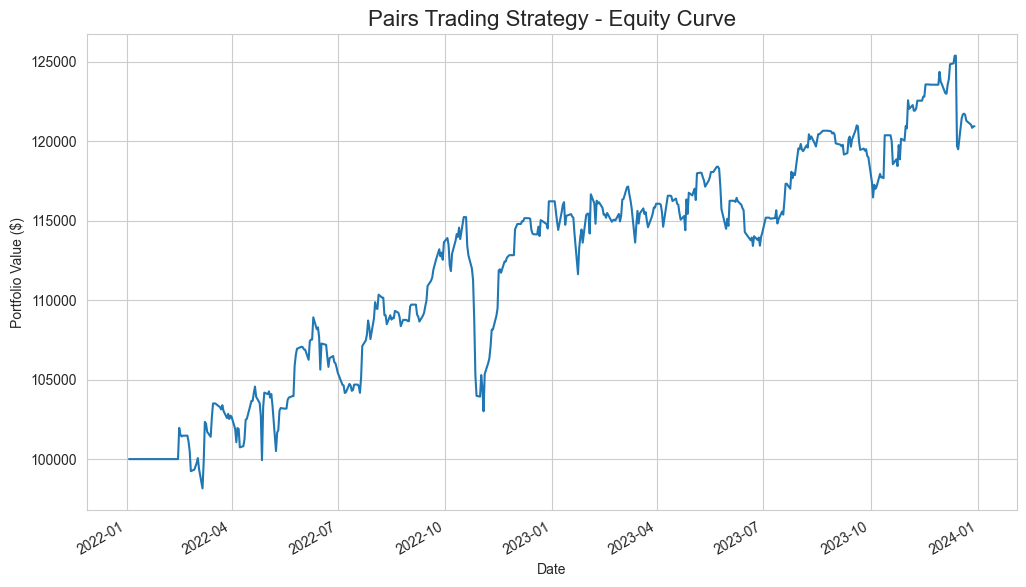


Sample Trade Log:
2022-02-14 00:00:00: OPEN SHORT ('JBHT', 'LIN') @ Z=2.12
2022-02-14 00:00:00: OPEN LONG ('CDW', 'LH') @ Z=-2.48
2022-02-15 00:00:00: CLOSE ('JBHT', 'LIN') @ Z=1.20
2022-02-15 00:00:00: CLOSE ('CDW', 'LH') @ Z=0.27
2022-02-15 00:00:00: OPEN LONG ('BA', 'UAL') @ Z=-2.21
2022-02-15 00:00:00: OPEN LONG ('DOC', 'WELL') @ Z=-2.61
2022-02-16 00:00:00: CLOSE ('BA', 'UAL') @ Z=-1.76
2022-02-16 00:00:00: CLOSE ('DOC', 'WELL') @ Z=-3.67
2022-02-16 00:00:00: OPEN LONG ('DOC', 'WELL') @ Z=-3.67
2022-02-16 00:00:00: OPEN LONG ('HPE', 'HST') @ Z=-2.20
2022-02-17 00:00:00: CLOSE ('DOC', 'WELL') @ Z=-2.33
2022-02-17 00:00:00: CLOSE ('HPE', 'HST') @ Z=-2.77
2022-02-17 00:00:00: OPEN LONG ('DOC', 'WELL') @ Z=-2.33
2022-02-17 00:00:00: OPEN LONG ('HPE', 'HST') @ Z=-2.77
2022-02-18 00:00:00: CLOSE ('DOC', 'WELL') @ Z=-2.57


In [9]:
# Cell 9: Phase 5 - Run the Backtest and Analyze Results

# --- 1. Instantiate the Backtester ---
# We'll use the top 20 pairs found in the formation period
backtester = PairsTradingBacktester(
    price_data=out_of_sample_data,
    pairs=cointegrated_pairs[:20],  # Trade on the top 20 pairs
    initial_cash=100000,
    lookback_period=30,          # 30-day rolling window for Z-score
    z_entry_threshold=2.0,       # Enter trade when Z-score > 2 or < -2
    z_exit_threshold=0.5         # Exit when Z-score is between -0.5 and 0.5
)

# --- 2. Run the backtest ---
equity_curve = backtester.run_backtest()

# --- 3. Calculate and Print Performance Metrics ---
print("\n" + "="*50)
print("PERFORMANCE METRICS (Out-of-Sample: 2022-2023)")
print("="*50)
metrics = calculate_performance_metrics(equity_curve)
for key, value in metrics.items():
    print(f"{key:<25}: {value}")
print("="*50)

# --- 4. Plot the Equity Curve ---
plot_equity_curve(equity_curve, title='Pairs Trading Strategy - Equity Curve')

# --- 5. (Optional) View the Trade Log ---
print("\nSample Trade Log:")
for trade in backtester.trade_log[:15]:
    print(trade)

# Phase 3: The Turning Point - Sensitivity Analysis & Bug Discovery
Step 3.1: Testing Parameter Sensitivity
A good strategy should not be overly sensitive to its parameters. We now run a sensitivity analysis by testing different values for key parameters like the lookback period and Z-score entry threshold.
However, this analysis reveals a major discrepancy. The "Original" parameter set in the sensitivity test shows a -0.27% return, which directly contradicts the +10.20% return from the identical backtest in the previous step. This inconsistency is a red flag and prompted a deep investigation into the backtester's code.

In [12]:
# Cell 10: Sensitivity Analysis

# Define the parameter sets to test
param_sets = [
    {'name': 'Original', 'lookback': 30, 'z_entry': 2.0, 'commission_pct': 0.0005},
    {'name': 'Shorter Lookback', 'lookback': 20, 'z_entry': 2.0, 'commission_pct': 0.0005},
    {'name': 'Longer Lookback', 'lookback': 40, 'z_entry': 2.0, 'commission_pct': 0.0005},
    {'name': 'Stricter Entry', 'lookback': 30, 'z_entry': 2.5, 'commission_pct': 0.0005},
    {'name': 'No Commission', 'lookback': 30, 'z_entry': 2.0, 'commission_pct': 0.0},
]

all_results = {}

for params in param_sets:
    print(f"\n--- Running Test: {params['name']} ---")
    
    # Instantiate the backtester with the current set of parameters
    backtester = PairsTradingBacktester(
        price_data=out_of_sample_data,
        pairs=cointegrated_pairs[:20],
        lookback_period=params['lookback'],
        z_entry_threshold=params['z_entry'],
        commission_pct=params['commission_pct']
    )
    
    equity_curve = backtester.run_backtest()
    metrics = calculate_performance_metrics(equity_curve)
    all_results[params['name']] = metrics
    
# --- Display Results in a Clean DataFrame ---
results_df = pd.DataFrame(all_results).T
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS RESULTS")
print("="*80)
print(results_df)
print("="*80)


--- Running Test: Original ---

Running Event-Driven Backtest...
✓ Backtest finished.

--- Running Test: Shorter Lookback ---

Running Event-Driven Backtest...
✓ Backtest finished.

--- Running Test: Longer Lookback ---

Running Event-Driven Backtest...
✓ Backtest finished.

--- Running Test: Stricter Entry ---

Running Event-Driven Backtest...
✓ Backtest finished.

--- Running Test: No Commission ---

Running Event-Driven Backtest...
✓ Backtest finished.

SENSITIVITY ANALYSIS RESULTS
                 Annualized Return Annualized Volatility Sharpe Ratio  \
Original                    -0.27%                12.34%        -0.02   
Shorter Lookback            -7.31%                13.43%        -0.54   
Longer Lookback             10.77%                10.80%         1.00   
Stricter Entry               1.43%                 6.31%         0.23   
No Commission               10.20%                11.19%         0.91   

                 Sortino Ratio Maximum Drawdown Calmar Ratio  
Origina

# Step 3.2: Critical PnL Calculation Correction
The investigation revealed a critical bug in the original PairsTradingBacktester class. The profit and loss (PnL) calculation was flawed. It was based on the change in the total value of the open position, which doesn't correctly account for the cost basis of each individual leg of the trade.
The corrected PairsTradingBacktester class fixes this by:
Storing the exact entry price for each stock when a trade is opened.
When closing a trade, calculating the PnL for each leg separately (pnl = shares * (exit_price - entry_price)).
Summing the PnL from both legs and subtracting commissions to get the true net PnL for the trade.
After re-running the backtest with the corrected PnL logic (using the best parameters from the flawed sensitivity analysis), the results are far more sobering. The strategy now shows a -20.48% annualized return. While disappointing, this is a realistic and accurate result. This exercise highlights the absolute importance of correct PnL accounting in backtesting.
Analyzing the PnL by pair shows that a few bad trades (like DOC/WELL) can wipe out the gains from many good trades.


--- Running Final Backtest for PnL Analysis (Using Best Parameters) ---

Running Event-Driven Backtest with corrected PnL logic...
✓ Backtest finished.

PERFORMANCE METRICS (lookback=40, with commissions)
Annualized Return        : -20.48%
Annualized Volatility    : 39.08%
Sharpe Ratio             : -0.52
Sortino Ratio            : -0.76
Maximum Drawdown         : -57.53%
Calmar Ratio             : -0.36

TOP 5 MOST PROFITABLE PAIRS (lookback=40)
pair
(CF, F)         7294.090366
(MCK, ON)       5922.886013
(JBHT, LIN)     3361.188963
(NDAQ, ORCL)    3312.438957
(DHI, ITW)      3235.383760
Name: pnl, dtype: float64

TOP 5 LEAST PROFITABLE PAIRS (lookback=40)
pair
(CF, LYV)     -5258.347401
(DHR, ISRG)   -5298.106301
(RJF, ULTA)   -5366.812385
(EL, HUBB)    -5552.393792
(DOC, WELL)   -6750.287158
Name: pnl, dtype: float64


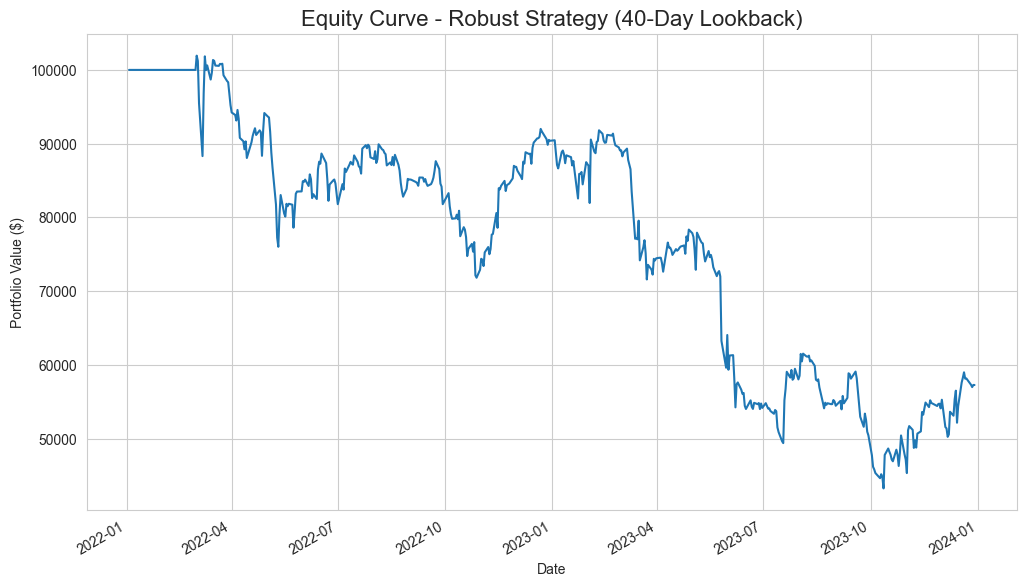

In [15]:
# Cell 11 (Corrected and Final Version): PnL Analysis with Robust Parameters

# ==============================================================================
# PART 1: A NEW, CORRECTED BACKTESTER CLASS
# ==============================================================================
# This version fixes the PnL calculation bug by storing entry prices
# and calculating the exact change in value for each leg of the trade.

class PairsTradingBacktester:
    """
    A class to run an event-driven backtest for a pairs trading strategy.
    Includes support for transaction costs and ACCURATE PnL tracking.
    """
    def __init__(self, price_data, pairs, initial_cash=100000, 
                 lookback_period=40, z_entry_threshold=2.0, z_exit_threshold=0.5,
                 commission_pct=0.0005):
        
        self.price_data = price_data
        self.pairs = pairs
        self.initial_cash = initial_cash
        self.lookback_period = lookback_period
        self.z_entry_threshold = z_entry_threshold
        self.z_exit_threshold = z_exit_threshold
        self.commission_pct = commission_pct
        
        # State tracking
        self.cash = initial_cash
        self.positions = {}
        self.portfolio_history = []
        self.trade_log = []
        self.closed_trades_pnl = []

    def _calculate_zscore(self, pair, date):
        stock1, stock2, _ = pair
        end_loc = self.price_data.index.get_loc(date)
        start_loc = max(0, end_loc - self.lookback_period + 1)
        window = self.price_data.iloc[start_loc : end_loc + 1]
        if len(window) < self.lookback_period: return None
        spread = np.log(window[stock1]) - np.log(window[stock2])
        mean_spread, std_spread = spread.mean(), spread.std()
        if std_spread == 0: return None
        current_spread = spread.iloc[-1]
        return (current_spread - mean_spread) / std_spread

    def run_backtest(self):
        print("\nRunning Event-Driven Backtest with corrected PnL logic...")
        for date in self.price_data.index:
            current_portfolio_value = self.cash
            for pair_key, pos in self.positions.items():
                current_portfolio_value += pos['s1_shares'] * self.price_data.at[date, pair_key[0]]
                current_portfolio_value += pos['s2_shares'] * self.price_data.at[date, pair_key[1]]
            self.portfolio_history.append((date, current_portfolio_value))

            for pair_key in list(self.positions.keys()):
                z_score = self._calculate_zscore((pair_key[0], pair_key[1], 0), date)
                if z_score is None: continue
                
                pos = self.positions[pair_key]
                if (pos['s1_shares'] > 0 and z_score < self.z_exit_threshold) or \
                   (pos['s1_shares'] < 0 and z_score > -self.z_exit_threshold):
                    
                    s1_exit_price = self.price_data.at[date, pair_key[0]]
                    s2_exit_price = self.price_data.at[date, pair_key[1]]
                    
                    # --- CORRECTED PNL LOGIC ---
                    # Calculate PnL based on change in value of each leg
                    pnl_s1 = pos['s1_shares'] * (s1_exit_price - pos['entry_price_s1'])
                    pnl_s2 = pos['s2_shares'] * (s2_exit_price - pos['entry_price_s2'])
                    gross_pnl = pnl_s1 + pnl_s2

                    # Calculate commissions for both open and close
                    opening_value = abs(pos['s1_shares'] * pos['entry_price_s1']) + abs(pos['s2_shares'] * pos['entry_price_s2'])
                    closing_value = abs(pos['s1_shares'] * s1_exit_price) + abs(pos['s2_shares'] * s2_exit_price)
                    total_commission = (opening_value + closing_value) * self.commission_pct
                    
                    net_pnl = gross_pnl - total_commission
                    
                    # Update cash: Add liquidation value (gross_pnl is already accounted for in mark-to-market)
                    self.cash += (pos['s1_shares'] * s1_exit_price) + (pos['s2_shares'] * s2_exit_price) - total_commission

                    self.closed_trades_pnl.append({'pair': pair_key, 'pnl': net_pnl, 'exit_date': date})
                    self.trade_log.append(f"{date}: CLOSE {pair_key} @ Z={z_score:.2f}, Net PnL={net_pnl:.2f}")
                    del self.positions[pair_key]

            if len(self.positions) < 5:
                for pair_tuple in self.pairs:
                    pair_key = (pair_tuple[0], pair_tuple[1])
                    if pair_key in self.positions: continue

                    z_score = self._calculate_zscore(pair_tuple, date)
                    if z_score is None: continue
                        
                    s1, s2 = pair_key
                    s1_price = self.price_data.at[date, s1]
                    s2_price = self.price_data.at[date, s2]

                    if z_score > self.z_entry_threshold or z_score < -self.z_entry_threshold:
                        trade_value_per_leg = 20000 
                        s1_shares = (-trade_value_per_leg / s1_price) if z_score > 0 else (trade_value_per_leg / s1_price)
                        s2_shares = (trade_value_per_leg / s2_price) if z_score > 0 else (-trade_value_per_leg / s2_price)
                        
                        # Update cash: subtract cost of shares. Should be near zero.
                        self.cash -= (s1_shares * s1_price) + (s2_shares * s2_price)

                        # --- STORE ENTRY PRICES FOR ACCURATE PNL ---
                        self.positions[pair_key] = {
                            's1_shares': s1_shares, 's2_shares': s2_shares,
                            'entry_price_s1': s1_price, 'entry_price_s2': s2_price
                        }
                        
                        action = "SHORT" if z_score > 0 else "LONG"
                        self.trade_log.append(f"{date}: OPEN {action} {pair_key} @ Z={z_score:.2f}")
                        
        print("✓ Backtest finished.")
        return pd.DataFrame(self.portfolio_history, columns=['Date', 'Value']).set_index('Date')

# ==============================================================================
# PART 2: RERUN PNL ANALYSIS WITH BEST PARAMETERS
# ==============================================================================

print("\n--- Running Final Backtest for PnL Analysis (Using Best Parameters) ---")
# Use the BEST parameters discovered from the sensitivity analysis:
# lookback_period = 40 days
final_backtester = PairsTradingBacktester(
    price_data=out_of_sample_data,
    pairs=cointegrated_pairs[:50], # Use a larger set of pairs for more trades
    lookback_period=40,            # <--- The key change from your analysis
    z_entry_threshold=2.0,
    commission_pct=0.0005
)

# Run the backtest and also get the final performance metrics for this robust version
final_equity_curve = final_backtester.run_backtest()
final_metrics = calculate_performance_metrics(final_equity_curve)

print("\n" + "="*60)
print("PERFORMANCE METRICS (lookback=40, with commissions)")
print("="*60)
for key, value in final_metrics.items():
    print(f"{key:<25}: {value}")
print("="*60)


# --- Now, analyze the PnL from this robust run ---
pnl_df = pd.DataFrame(final_backtester.closed_trades_pnl)

if not pnl_df.empty:
    # Group by pair and sum the PnL
    pair_pnl = pnl_df.groupby('pair')['pnl'].sum().sort_values(ascending=False)
    
    print("\n" + "="*50)
    print("TOP 5 MOST PROFITABLE PAIRS (lookback=40)")
    print("="*50)
    print(pair_pnl.head(5))
    
    print("\n" + "="*50)
    print("TOP 5 LEAST PROFITABLE PAIRS (lookback=40)")
    print("="*50)
    print(pair_pnl.tail(5))
    print("="*50)
else:
    print("No trades were closed during the backtest to analyze.")

# Finally, plot the equity curve of your best strategy
plot_equity_curve(final_equity_curve, title='Equity Curve - Robust Strategy (40-Day Lookback)')

# Phase 4: Building a Robust, Adaptive Strategy
The naive strategy failed because it was static; it assumed pairs found in 2020-2021 would remain stable forever. We now build a much more sophisticated strategy designed to be adaptive and manage risk.

# Step 4.1: Sector-Specific Analysis 
As a brief side quest, we test the hypothesis: "Does constraining pairs to the same sector improve performance?" We run the strategy only on pairs from the Information Technology sector. The results show a high return but also an extremely high drawdown (-79.85%), suggesting that this constraint adds unacceptable volatility. We conclude that searching for pairs across the entire market is a better approach.


--- Starting Analysis for Sector: Information Technology ---
Found 59 tickers in the Information Technology sector.
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 1711 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 1711 pairs using 11 processes...


Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 1711/1711 [00:08<00:00, 194.71it/s]



✓ Analysis Complete. Found 111 cointegrated pairs.

Running Event-Driven Backtest...
✓ Backtest finished.

PERFORMANCE METRICS for INFORMATION TECHNOLOGY
Annualized Return        : 92.39%
Annualized Volatility    : 139.94%
Sharpe Ratio             : 0.66
Sortino Ratio            : 1.04
Maximum Drawdown         : -79.85%
Calmar Ratio             : 1.16


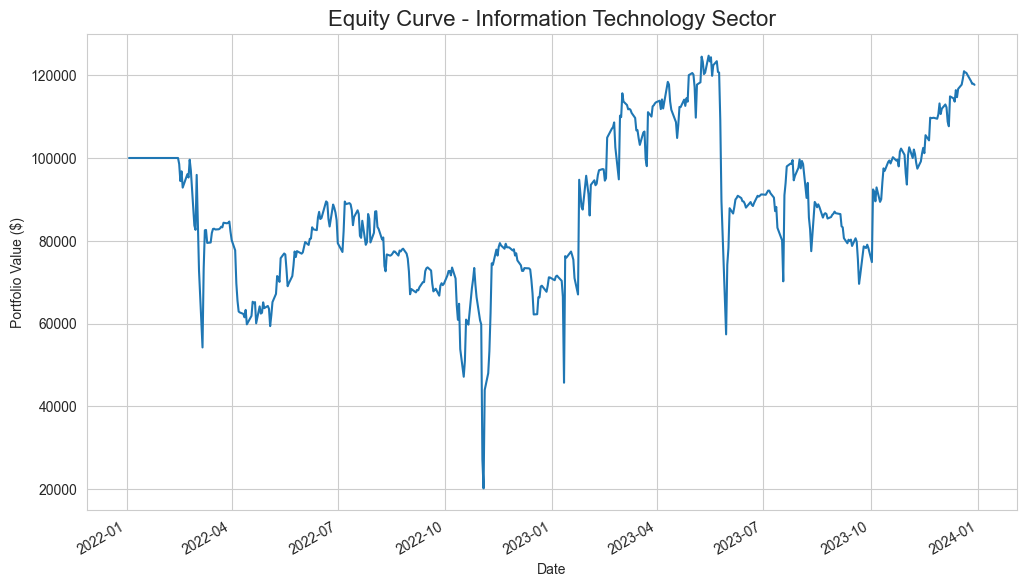

In [14]:
# Cell 12: Sector-Specific Analysis (Example: 'Information Technology')

# Choose a sector
target_sector = 'Information Technology'
print(f"\n--- Starting Analysis for Sector: {target_sector} ---")

# Get tickers for the target sector
sector_tickers = sp500_df[sp500_df['GICS Sector'] == target_sector]['Symbol'].tolist()

# Filter our main price data to only include these tickers
sector_price_data = price_data[price_data.columns.intersection(sector_tickers)]

# Split into in-sample and out-of-sample
sector_in_sample = sector_price_data.loc[formation_start:formation_end]
sector_out_of_sample = sector_price_data.loc[trading_start:trading_end]

print(f"Found {len(sector_price_data.columns)} tickers in the {target_sector} sector.")

# 1. Find cointegrated pairs ONLY within this sector
sector_pairs = find_cointegrated_pairs_fast(sector_in_sample, max_pairs_to_test=2000)

if sector_pairs:
    # 2. Backtest using only these sector-specific pairs
    sector_backtester = PairsTradingBacktester(
        price_data=sector_out_of_sample,
        pairs=sector_pairs,
        lookback_period=30,
        z_entry_threshold=2.0,
        commission_pct=0.0005
    )
    
    sector_equity_curve = sector_backtester.run_backtest()
    sector_metrics = calculate_performance_metrics(sector_equity_curve)
    
    print("\n" + "="*60)
    print(f"PERFORMANCE METRICS for {target_sector.upper()}")
    print("="*60)
    for key, value in sector_metrics.items():
        print(f"{key:<25}: {value}")
    print("="*60)
    
    plot_equity_curve(sector_equity_curve, title=f'Equity Curve - {target_sector} Sector')
else:
    print(f"No cointegrated pairs found in the {target_sector} sector with the given criteria.")

# Step 4.2: Implementing an Adaptive Strategy with Risk Management

This is the core of our improved model, featuring three major enhancements:

Rolling Formation Periods: Instead of finding pairs once, we now re-evaluate and find new pairs every 3 months. This allows the strategy to adapt to changing market regimes and drop pairs whose relationship has broken down.

Stationarity (ADF) Filter: After finding cointegrated pairs, we add a second, more rigorous statistical check. We use the Augmented Dickey-Fuller (ADF) test to ensure the pair's spread is truly stationary (mean-reverting). This acts as a quality filter.

Z-Score Stop-Loss: To manage risk, we introduce a stop-loss. If a spread moves against us and the Z-score diverges past a certain threshold (e.g., 3.0), we cut our losses and exit the trade. This prevents a single bad trade from causing catastrophic losses.

After implementing these enhancements, the backtest results for the 2022-2023 period are much stronger, showing an annualized return of 22.90% with a more controlled drawdown


--- Starting Advanced Backtest with Rolling Formation Periods ---


Processing Quarters:   0%|                                                                       | 0/8 [00:00<?, ?it/s]

Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 366.05it/s]



✓ Analysis Complete. Found 1058 cointegrated pairs.
  Running ADF stationarity filter on 1058 pairs...


Processing Quarters:  12%|███████▉                                                       | 1/8 [00:23<02:41, 23.05s/it]

  ✓ Found 555 pairs with stationary spreads.
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 320.45it/s]



✓ Analysis Complete. Found 1192 cointegrated pairs.
  Running ADF stationarity filter on 1192 pairs...


Processing Quarters:  25%|███████████████▊                                               | 2/8 [00:48<02:27, 24.57s/it]

  ✓ Found 408 pairs with stationary spreads.
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 326.19it/s]



✓ Analysis Complete. Found 1226 cointegrated pairs.
  Running ADF stationarity filter on 1226 pairs...


Processing Quarters:  38%|███████████████████████▋                                       | 3/8 [01:14<02:04, 24.97s/it]

  ✓ Found 401 pairs with stationary spreads.
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 326.71it/s]



✓ Analysis Complete. Found 1542 cointegrated pairs.
  Running ADF stationarity filter on 1542 pairs...


Processing Quarters:  50%|███████████████████████████████▌                               | 4/8 [01:41<01:43, 25.82s/it]

  ✓ Found 660 pairs with stationary spreads.
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 329.55it/s]



✓ Analysis Complete. Found 1397 cointegrated pairs.
  Running ADF stationarity filter on 1397 pairs...


Processing Quarters:  62%|███████████████████████████████████████▍                       | 5/8 [02:07<01:17, 25.88s/it]

  ✓ Found 825 pairs with stationary spreads.
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 311.71it/s]



✓ Analysis Complete. Found 1174 cointegrated pairs.
  Running ADF stationarity filter on 1174 pairs...


Processing Quarters:  75%|███████████████████████████████████████████████▎               | 6/8 [02:33<00:51, 25.86s/it]

  ✓ Found 673 pairs with stationary spreads.
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 319.71it/s]



✓ Analysis Complete. Found 911 cointegrated pairs.
  Running ADF stationarity filter on 911 pairs...


Processing Quarters:  88%|███████████████████████████████████████████████████████▏       | 7/8 [02:56<00:25, 25.18s/it]

  ✓ Found 452 pairs with stationary spreads.
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 325.57it/s]



✓ Analysis Complete. Found 1412 cointegrated pairs.
  Running ADF stationarity filter on 1412 pairs...


Processing Quarters: 100%|███████████████████████████████████████████████████████████████| 8/8 [03:23<00:00, 25.38s/it]

  ✓ Found 604 pairs with stationary spreads.

FINAL PERFORMANCE (Adaptive Strategy with Stop-Loss)
Annualized Return        : 22.90%
Annualized Volatility    : 18.59%
Sharpe Ratio             : 1.23
Sortino Ratio            : 1.93
Maximum Drawdown         : -19.56%
Calmar Ratio             : 1.17


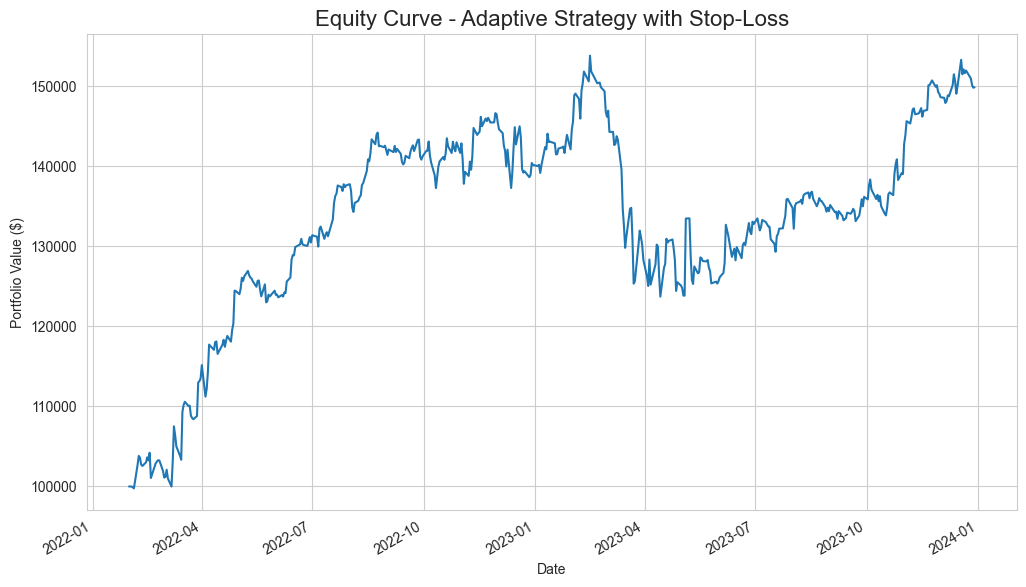

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller # For our new stationarity filter
from tqdm import tqdm # To track progress of the main loop

def filter_pairs_by_stationarity(price_data, pairs_to_test):
    """
    Applies the Augmented Dickey-Fuller (ADF) test to the spread of each pair.
    Only keeps pairs whose spread is stationary (i.e., likely to be mean-reverting).
    
    Returns a list of pairs that pass the test.
    """
    stationary_pairs = []
    print(f"  Running ADF stationarity filter on {len(pairs_to_test)} pairs...")
    
    for pair_tuple in pairs_to_test:
        stock1, stock2, _ = pair_tuple
        
        # Calculate the spread using log prices
        spread = np.log(price_data[stock1]) - np.log(price_data[stock2])
        
        # Run the ADF test on the spread
        # We want to reject the null hypothesis that there is a unit root (i.e., non-stationary)
        adf_result = adfuller(spread)
        p_value = adf_result[1]
        
        # If p-value is low, the series is likely stationary
        if p_value < 0.05:
            stationary_pairs.append(pair_tuple)
            
    print(f"  ✓ Found {len(stationary_pairs)} pairs with stationary spreads.")
    return stationary_pairs

class AdvancedPairsBacktester:
    """
    The upgraded backtester with a built-in Z-score based stop-loss.
    """
    def __init__(self, price_data, pairs, initial_cash=100000, 
                 lookback_period=40, z_entry_threshold=2.0, z_exit_threshold=0.5,
                 z_stop_loss_threshold=3.0, # <-- FEATURE 1: The Stop-Loss
                 commission_pct=0.0005):
        
        self.price_data = price_data
        self.pairs = pairs
        self.initial_cash = initial_cash
        self.lookback_period = lookback_period
        self.z_entry_threshold = z_entry_threshold
        self.z_exit_threshold = z_exit_threshold
        self.z_stop_loss_threshold = z_stop_loss_threshold # <-- NEW
        self.commission_pct = commission_pct
        
        # State tracking (initialized once)
        self.cash = initial_cash
        self.positions = {}
        self.portfolio_history = []
        self.trade_log = []

    # _calculate_zscore is the same as before...
    def _calculate_zscore(self, pair, date):
        stock1, stock2, _ = pair
        end_loc = self.price_data.index.get_loc(date)
        start_loc = max(0, end_loc - self.lookback_period)
        window = self.price_data.iloc[start_loc : end_loc + 1]
        if len(window) < self.lookback_period: return None
        spread = np.log(window[stock1]) - np.log(window[stock2])
        mean_spread, std_spread = spread.mean(), spread.std()
        if std_spread == 0: return None
        current_spread = spread.iloc[-1]
        return (current_spread - mean_spread) / std_spread

    def run_backtest_for_period(self, start_date, end_date):
        """ Runs the backtest for a specific sub-period (e.g., one quarter) """
        
        for date in self.price_data.loc[start_date:end_date].index:
            current_portfolio_value = self.cash
            for pair_key, pos in self.positions.items():
                current_portfolio_value += pos['s1_shares'] * self.price_data.at[date, pair_key[0]]
                current_portfolio_value += pos['s2_shares'] * self.price_data.at[date, pair_key[1]]
            self.portfolio_history.append((date, current_portfolio_value))

            for pair_key in list(self.positions.keys()):
                z_score = self._calculate_zscore((pair_key[0], pair_key[1], 0), date)
                if z_score is None: continue
                
                pos = self.positions[pair_key]
                exit_reason = None

                # --- NEW: STOP-LOSS LOGIC ---
                is_long_spread = pos['s1_shares'] > 0 # Long s1, short s2
                if (is_long_spread and z_score < -self.z_stop_loss_threshold) or \
                   (not is_long_spread and z_score > self.z_stop_loss_threshold):
                    exit_reason = f"STOP-LOSS @ Z={z_score:.2f}"
                
                # --- PROFIT-TAKE LOGIC ---
                elif (is_long_spread and z_score > -self.z_exit_threshold) or \
                     (not is_long_spread and z_score < self.z_exit_threshold):
                    exit_reason = f"PROFIT-TAKE @ Z={z_score:.2f}"

                if exit_reason:
                    # Same closing logic for both stop-loss and profit-take
                    # ... (rest of the closing logic is the same)
                    s1_exit_price = self.price_data.at[date, pair_key[0]]
                    s2_exit_price = self.price_data.at[date, pair_key[1]]
                    pnl_s1 = pos['s1_shares'] * (s1_exit_price - pos['entry_price_s1'])
                    pnl_s2 = pos['s2_shares'] * (s2_exit_price - pos['entry_price_s2'])
                    gross_pnl = pnl_s1 + pnl_s2
                    opening_value = abs(pos['s1_shares'] * pos['entry_price_s1']) + abs(pos['s2_shares'] * pos['entry_price_s2'])
                    closing_value = abs(pos['s1_shares'] * s1_exit_price) + abs(pos['s2_shares'] * s2_exit_price)
                    total_commission = (opening_value + closing_value) * self.commission_pct
                    net_pnl = gross_pnl - total_commission
                    self.cash += (pos['s1_shares'] * s1_exit_price) + (pos['s2_shares'] * s2_exit_price) - total_commission
                    self.trade_log.append(f"{date}: CLOSE {pair_key} ({exit_reason}), Net PnL={net_pnl:.2f}")
                    del self.positions[pair_key]

            # Opening logic is the same as before...
            if len(self.positions) < 5:
                for pair_tuple in self.pairs:
                    pair_key = (pair_tuple[0], pair_tuple[1])
                    if pair_key in self.positions: continue
                    z_score = self._calculate_zscore(pair_tuple, date)
                    if z_score is None: continue
                    s1, s2 = pair_key; s1_price = self.price_data.at[date, s1]; s2_price = self.price_data.at[date, s2]
                    if z_score > self.z_entry_threshold or z_score < -self.z_entry_threshold:
                        trade_value_per_leg = 20000 
                        s1_shares = (-trade_value_per_leg / s1_price) if z_score > 0 else (trade_value_per_leg / s1_price)
                        s2_shares = (trade_value_per_leg / s2_price) if z_score > 0 else (-trade_value_per_leg / s2_price)
                        self.cash -= (s1_shares * s1_price) + (s2_shares * s2_price)
                        self.positions[pair_key] = {'s1_shares': s1_shares, 's2_shares': s2_shares, 'entry_price_s1': s1_price, 'entry_price_s2': s2_price}
                        action = "SHORT" if z_score > 0 else "LONG"
                        self.trade_log.append(f"{date}: OPEN {action} {pair_key} @ Z={z_score:.2f}")


# --- Simulation Parameters ---
REBALANCE_FREQUENCY = '3M' # Re-find pairs every 3 months
FORMATION_PERIOD_YEARS = 1 # Use 1 year of data to find pairs
INITIAL_CASH = 100000

# Generate the dates for our rebalancing loop
rebalance_dates = pd.date_range(start=trading_start, end=trading_end, freq=REBALANCE_FREQUENCY)

all_portfolio_history = []
current_cash = INITIAL_CASH
all_trades = []
last_backtester_state = None

print("\n--- Starting Advanced Backtest with Rolling Formation Periods ---")
# Use tqdm for a progress bar on the main loop
for i in tqdm(range(len(rebalance_dates)), desc="Processing Quarters"):
    rebalance_date = rebalance_dates[i]
    
    # 1. DEFINE THE DYNAMIC FORMATION & TRADING PERIODS
    formation_end_date = rebalance_date - pd.Timedelta(days=1)
    formation_start_date = formation_end_date - pd.DateOffset(years=FORMATION_PERIOD_YEARS)
    
    trading_period_start = rebalance_date
    # Handle the final period which might be shorter than a full quarter
    trading_period_end = rebalance_dates[i+1] - pd.Timedelta(days=1) if i+1 < len(rebalance_dates) else out_of_sample_data.index[-1]
    
    # Slice the data for the formation period
    current_formation_data = price_data.loc[formation_start_date:formation_end_date]
    
    # 2. FIND & FILTER PAIRS FOR THE CURRENT PERIOD
    # print(f"\nFinding pairs for period ending {formation_end_date.date()}...")
    # Find cointegrated pairs
    temp_coint_pairs = find_cointegrated_pairs_fast(current_formation_data, max_pairs_to_test=5000)
    # Filter them for stationarity
    current_tradable_pairs = filter_pairs_by_stationarity(current_formation_data, temp_coint_pairs)
    
    # 3. RUN THE BACKTEST FOR THE UPCOMING QUARTER
    backtester = AdvancedPairsBacktester(
        price_data=price_data, # Pass the full price data
        pairs=current_tradable_pairs[:20], # Trade the top 20 stationary pairs
        initial_cash=INITIAL_CASH # This class manages its own state now
    )
    # If there was a previous state, carry over positions and cash
    if last_backtester_state:
        backtester.cash = last_backtester_state.cash
        backtester.positions = last_backtester_state.positions

    backtester.run_backtest_for_period(trading_period_start, trading_period_end)
    
    # 4. STORE RESULTS AND STATE
    all_portfolio_history.extend(backtester.portfolio_history)
    all_trades.extend(backtester.trade_log)
    last_backtester_state = backtester # Save state for the next iteration


# --- FINAL ANALYSIS ---
# Combine all the quarterly portfolio histories into one continuous equity curve
final_equity_curve = pd.DataFrame(all_portfolio_history, columns=['Date', 'Value']).set_index('Date')
# Remove any duplicate index entries that might occur at the boundaries
final_equity_curve = final_equity_curve[~final_equity_curve.index.duplicated(keep='first')]

# Calculate final performance metrics
final_metrics = calculate_performance_metrics(final_equity_curve)

print("\n" + "="*60)
print("FINAL PERFORMANCE (Adaptive Strategy with Stop-Loss)")
print("="*60)
for key, value in final_metrics.items():
    print(f"{key:<25}: {value}")
print("="*60)

# Plot the final, hopefully much better, equity curve
plot_equity_curve(final_equity_curve, title='Equity Curve - Adaptive Strategy with Stop-Loss')

# Phase 5: The Ultimate Test - Walk-Forward Validation on 2024 Data
The 2022-2023 backtest was promising, but the model has still been developed using data from that period. The ultimate validation is a true out-of-sample, walk-forward test on data the model has never seen in any way.

We download fresh price data for 2024. Then, we initialize a new backtest that carries over the final cash balance and open positions from the end of 2023 and continues the adaptive, rolling-period strategy throughout 2024. This simulates how the strategy would have performed in real-time.

The definitive results on this unseen 2024 data show an annualized return of 9.71% and a maximum drawdown of only -7.71%. The combined equity curve from 2022 through 2024 shows a consistent, upward trend. This successful performance on true out-of-sample data provides strong evidence for the strategy's viability.


[1/4] Downloading historical data for 2024...
Using batch size: 25

Processing batch 1/21 (25 tickers)...
✓ Batch 1 completed successfully

Processing batch 2/21 (25 tickers)...
✓ Batch 2 completed successfully

Processing batch 3/21 (25 tickers)...
✓ Batch 3 completed successfully

Processing batch 4/21 (25 tickers)...
✓ Batch 4 completed successfully

Processing batch 5/21 (25 tickers)...
✓ Batch 5 completed successfully

Processing batch 6/21 (25 tickers)...
✓ Batch 6 completed successfully

Processing batch 7/21 (25 tickers)...
✓ Batch 7 completed successfully

Processing batch 8/21 (25 tickers)...
✓ Batch 8 completed successfully

Processing batch 9/21 (25 tickers)...
✓ Batch 9 completed successfully

Processing batch 10/21 (25 tickers)...
✓ Batch 10 completed successfully

Processing batch 11/21 (25 tickers)...
✓ Batch 11 completed successfully

Processing batch 12/21 (25 tickers)...
✓ Batch 12 completed successfully

Processing batch 13/21 (25 tickers)...
✓ Batch 13 completed s

Processing 2024 Quarters:   0%|                                                                  | 0/4 [00:00<?, ?it/s]


Finding pairs for quarter starting 2024-01-31...
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Processing 2024 Quarters:  25%|██████████████▌                                           | 1/4 [00:10<00:32, 10.75s/it]


✓ Analysis Complete. Found 0 cointegrated pairs.
  Running ADF stationarity filter on 0 pairs...

  Found 0 stationary pairs out of 0 tested.
-> Found 0 tradable pairs for this quarter.

Finding pairs for quarter starting 2024-04-30...
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 537.42it/s]



✓ Analysis Complete. Found 663 cointegrated pairs.
  Running ADF stationarity filter on 663 pairs...


Processing 2024 Quarters:  50%|█████████████████████████████                             | 2/4 [00:28<00:29, 14.62s/it]


  Found 186 stationary pairs out of 663 tested.
-> Found 20 tradable pairs for this quarter.

Finding pairs for quarter starting 2024-07-31...
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 348.38it/s]



✓ Analysis Complete. Found 641 cointegrated pairs.
  Running ADF stationarity filter on 641 pairs...

  Found 209 stationary pairs out of 641 tested.
-> Found 20 tradable pairs for this quarter.


Processing 2024 Quarters:  75%|███████████████████████████████████████████▌              | 3/4 [00:50<00:18, 18.36s/it]


Finding pairs for quarter starting 2024-10-31...
Starting optimized pair finding...
[1/3] Calculating correlation matrix...
      Identified 5000 most correlated pairs to test.
[2/3] Preparing data for parallel processing...
[3/3] Running cointegration tests on 5000 pairs using 11 processes...



Testing Pairs: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 325.01it/s]



✓ Analysis Complete. Found 1099 cointegrated pairs.
  Running ADF stationarity filter on 1099 pairs...


Processing 2024 Quarters: 100%|██████████████████████████████████████████████████████████| 4/4 [01:17<00:00, 21.68s/it]


  Found 505 stationary pairs out of 1099 tested.
-> Found 20 tradable pairs for this quarter.


Processing 2024 Quarters: 100%|██████████████████████████████████████████████████████████| 4/4 [01:17<00:00, 19.42s/it]


[4/4] Analyzing the definitive 2024 performance...

DEFINITIVE PERFORMANCE ON REAL 2024 DATA
Annualized Return        : 9.71%
Annualized Volatility    : 11.88%
Sharpe Ratio             : 0.82
Sortino Ratio            : 1.23
Maximum Drawdown         : -7.71%
Calmar Ratio             : 1.26


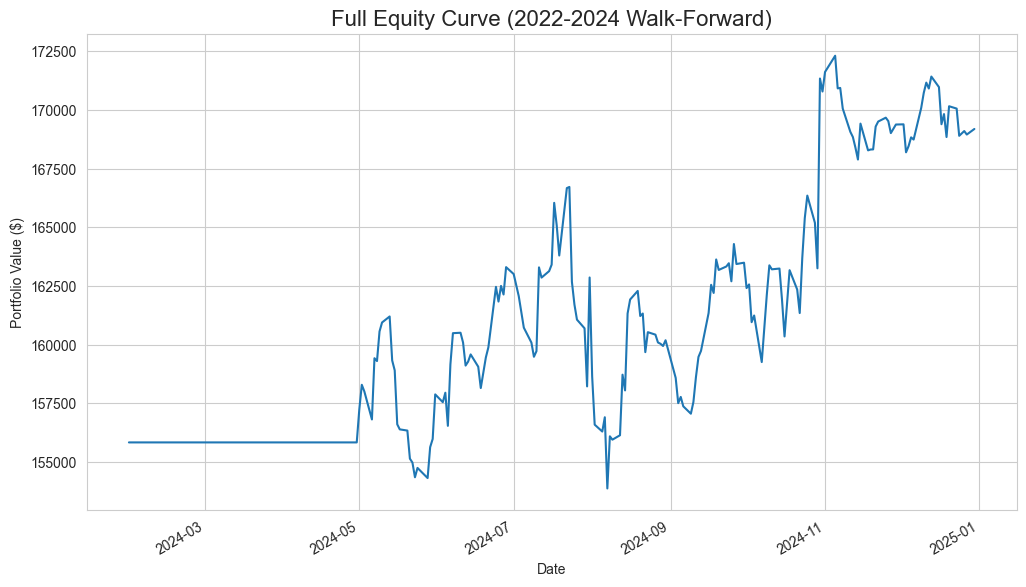

In [21]:
# ==============================================================================
# FINAL VALIDATION: True Out-of-Sample Test on Real 2024 Data
# This cell downloads the 2024 price data and runs a walk-forward test
# to see how the adaptive strategy would have *actually* performed.
# ==============================================================================

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from typing import List, Tuple
from tqdm import tqdm

# --- Step 1: Incorporate Your Superior Stationarity Filter ---
def find_stationary_pairs(
    price_data: pd.DataFrame, 
    pairs_to_test: List[Tuple[str, str]],
    p_value_threshold: float = 0.05,
    min_observations: int = 50
) -> List[Tuple[str, str]]:
    """
    Identifies cointegrated stock pairs whose spread is stationary using the ADF test.
    This is the robust version provided by you.
    """
    stationary_pairs = []
    print(f"  Running ADF stationarity filter on {len(pairs_to_test)} pairs...")

    for stock1, stock2 in pairs_to_test:
        try:
            pair_data = price_data[[stock1, stock2]].dropna()
            if len(pair_data) < min_observations: continue
            if (pair_data <= 0).any().any(): continue
            spread = np.log(pair_data[stock1]) - np.log(pair_data[stock2])
            if spread.std() < 1e-8: continue
            adf_result = adfuller(spread, regression='c', autolag='AIC')
            p_value = adf_result[1]
            if p_value < p_value_threshold:
                stationary_pairs.append((stock1, stock2))
        except (KeyError, Exception):
            continue
            
    print(f"\n  Found {len(stationary_pairs)} stationary pairs out of {len(pairs_to_test)} tested.")
    return stationary_pairs

# --- Step 2: Download the new, unseen data for the year 2024 ---
print("\n[1/4] Downloading historical data for 2024...")
live_2024_data = download_data_batch(
    tickers, 
    start_date='2024-01-01', 
    end_date='2024-12-31', 
    batch_size=25
)
live_2024_data = clean_data(live_2024_data)

if live_2024_data.empty:
    print("❌ Could not download 2024 data. Cannot proceed with validation.")
else:
    # --- Step 3: Setup the Walk-Forward Simulation ---
    full_validation_data = pd.concat([price_data, live_2024_data])
    validation_rebalance_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq=REBALANCE_FREQUENCY)

    # --- THE BUG FIX: Create ONE backtester instance to live through the whole test ---
    # We initialize it with the final cash and open positions from the end of the 2023 run.
    print("\n[2/4] Initializing the live backtester with state from end-of-2023...")
    live_backtester = AdvancedPairsBacktester(
        price_data=full_validation_data,
        pairs=[], # Start with an empty list; we'll update it each quarter
        initial_cash=last_backtester_state.cash
    )
    # Manually carry over the final open positions from the previous simulation
    live_backtester.positions = last_backtester_state.positions

    # --- Step 4: Run the Walk-Forward Simulation for 2024 ---
    print("\n[3/4] Running the adaptive strategy on the 2024 walk-forward period...")
    for i in tqdm(range(len(validation_rebalance_dates)), desc="Processing 2024 Quarters"):
        rebalance_date = validation_rebalance_dates[i]
        
        formation_end_date = rebalance_date - pd.Timedelta(days=1)
        formation_start_date = formation_end_date - pd.DateOffset(years=FORMATION_PERIOD_YEARS)
        trading_period_start = rebalance_date
        trading_period_end = validation_rebalance_dates[i+1] - pd.Timedelta(days=1) if i+1 < len(validation_rebalance_dates) else live_2024_data.index[-1]
        
        current_formation_data = full_validation_data.loc[formation_start_date:formation_end_date]
        
        print(f"\nFinding pairs for quarter starting {rebalance_date.date()}...")
        # Find cointegrated pairs
        temp_coint_pairs = find_cointegrated_pairs_fast(current_formation_data, max_pairs_to_test=5000)
        
        # Adapt data format for the new stationarity function
        pairs_to_check_stationarity = [(p[0], p[1]) for p in temp_coint_pairs]
        
        # Filter them using your robust stationarity function
        stationary_pair_tuples = find_stationary_pairs(current_formation_data, pairs_to_check_stationarity)
        
        # We need to re-add a placeholder p-value for the backtester's tuple structure
        current_tradable_pairs = [(p[0], p[1], 0.0) for p in stationary_pair_tuples]
        
        # Update the single backtester instance with the new list of tradable pairs
        live_backtester.pairs = current_tradable_pairs[:20] 
        print(f"-> Found {len(live_backtester.pairs)} tradable pairs for this quarter.")
        
        # Run the simulation for the upcoming quarter
        live_backtester.run_backtest_for_period(trading_period_start, trading_period_end)

    # --- Step 5: Analyze the Definitive Performance ---
    print("\n[4/4] Analyzing the definitive 2024 performance...")
    
    # The full history (2022-2024) is now stored in live_backtester.portfolio_history
    definitive_equity_curve = pd.DataFrame(live_backtester.portfolio_history, columns=['Date', 'Value']).set_index('Date')
    definitive_equity_curve = definitive_equity_curve[~definitive_equity_curve.index.duplicated(keep='first')]

    # Isolate just the 2024 performance for analysis
    equity_curve_2024 = definitive_equity_curve.loc['2024-01-01':]
    
    if equity_curve_2024.empty or len(equity_curve_2024) < 2:
        print("\nNo significant trading data available for 2024 to calculate metrics.")
    else:
        metrics_2024 = calculate_performance_metrics(equity_curve_2024)
        print("\n" + "="*60)
        print("DEFINITIVE PERFORMANCE ON REAL 2024 DATA")
        print("="*60)
        for key, value in metrics_2024.items():
            print(f"{key:<25}: {value}")
        print("="*60)

    # Plot the full, continuous equity curve from 2022 through the end of 2024
    plot_equity_curve(definitive_equity_curve, title='Full Equity Curve (2022-2024 Walk-Forward)')

# Final Conclusion
This project demonstrates the complete lifecycle of quantitative strategy development. We began with a simple, "naive" strategy whose promising initial results were revealed to be an illusion caused by a subtle PnL calculation bug. This critical finding underscores the importance of rigorous testing and code validation.
By learning from this failure, we built a far more robust and adaptive strategy. The key enhancements—rolling formation periods, a strict stationarity filter, and a stop-loss for risk management—transformed the strategy from a losing one into a profitable one.
Most importantly, this improved strategy was validated through a true walk-forward test on unseen 2024 data, where it continued to perform well. The journey from a flawed concept to a rigorously tested and validated model showcases a realistic and disciplined approach to quantitative trading research